In [29]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import gensim.downloader as api


In [21]:
folder_path_train = "..\\data\\balanced\\train"
folder_path_test = "..\\data\\balanced\\test"
names = ["Facebook", "Reddit", "Twitter", "Youtube"]

# Load datasets
dfs_train = {n: pd.read_csv(os.path.join(folder_path_train, f"balanced_{n.lower()}_train.csv")) for n in names}
dfs_test = {n: pd.read_csv(os.path.join(folder_path_test, f"balanced_{n.lower()}_test.csv")) for n in names}


In [22]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing
for name in names:
    dfs_train[name]['tokens'] = dfs_train[name]['text'].apply(preprocess_text)
    dfs_test[name]['tokens'] = dfs_test[name]['text'].apply(preprocess_text)
    dfs_train[name]['label'] = dfs_train[name]['label'].astype(int)
    dfs_test[name]['label'] = dfs_test[name]['label'].astype(int)


In [24]:
path = api.load("word2vec-google-news-300", return_path=True)

word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)


In [25]:
def get_sentence_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

for name in names:
    dfs_train[name]['embedding'] = dfs_train[name]['tokens'].apply(lambda x: get_sentence_embedding(x, word2vec_model))
    dfs_test[name]['embedding'] = dfs_test[name]['tokens'].apply(lambda x: get_sentence_embedding(x, word2vec_model))


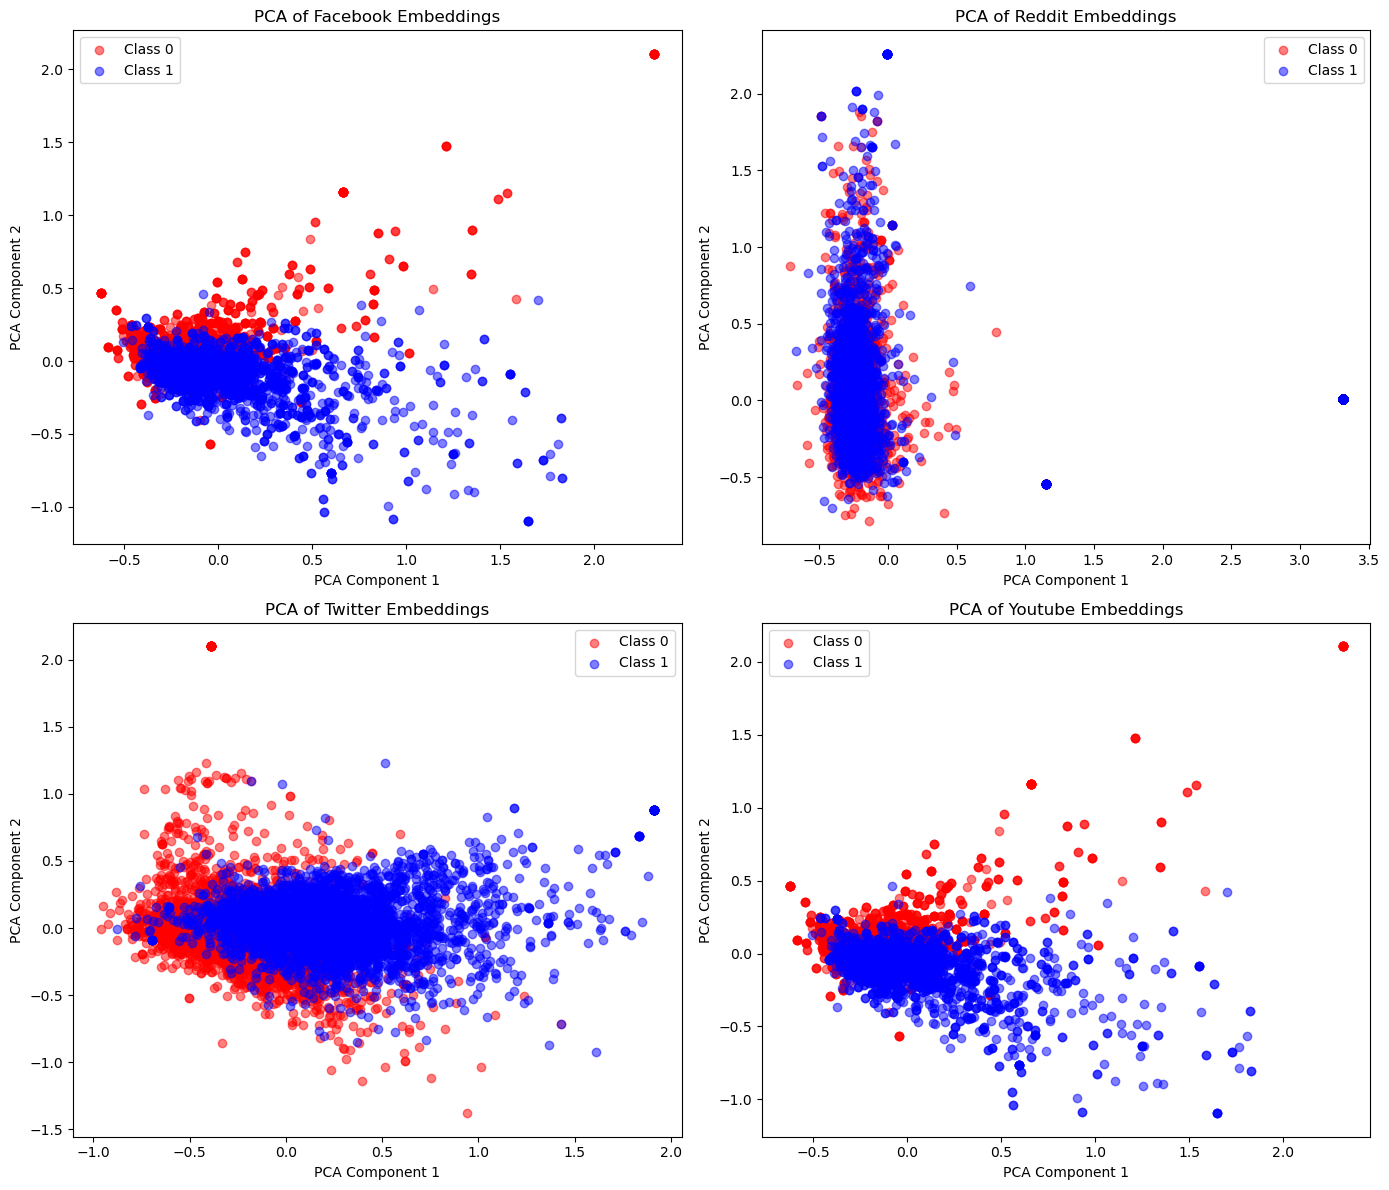

In [26]:
# Plot embeddings for each dataset using PCA
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for ax, name in zip(axs.flatten(), names):
    pca = PCA(n_components=2)
    embeddings = np.vstack(dfs_train[name]['embedding'].values)
    labels = dfs_train[name]['label'].values
    reduced_embeddings = pca.fit_transform(embeddings)
    
    ax.scatter(reduced_embeddings[labels == 0, 0], reduced_embeddings[labels == 0, 1], c='red', label='Class 0', alpha=0.5)
    ax.scatter(reduced_embeddings[labels == 1, 0], reduced_embeddings[labels == 1, 1], c='blue', label='Class 1', alpha=0.5)
    ax.set_title(f'PCA of {name} Embeddings')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend()

plt.tight_layout()
plt.show()

In [30]:
results = []
for name in names:
    X_train = np.vstack(dfs_train[name]['embedding'].values)
    y_train = dfs_train[name]['label']
    
    X_test = np.vstack(dfs_test[name]['embedding'].values)
    y_test = dfs_test[name]['label']
    
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Collect results for each class
    for cls in ['0', '1']:
        results.append({
            'Dataset': name,
            'Class': cls,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Accuracy': np.nan  # Accuracy is not class-specific
        })
    
    # Include the overall metrics for the dataset
    results.append({
        'Dataset': name,
        'Class': 'overall',
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

     Dataset    Class  Precision    Recall  F1-Score  Accuracy
0   Facebook        0   0.692308  0.575581  0.628571       NaN
1   Facebook        1   0.854582  0.906977  0.880000       NaN
2   Facebook  overall   0.811309  0.818605  0.812952  0.818605
3     Reddit        0   0.843455  0.633660  0.723659       NaN
4     Reddit        1   0.300194  0.571956  0.393734       NaN
5     Reddit  overall   0.726363  0.620361  0.652548  0.620361
6    Twitter        0   0.544687  0.929172  0.686779       NaN
7    Twitter        1   0.983314  0.843113  0.907833       NaN
8    Twitter  overall   0.909605  0.857575  0.870686  0.857575
9    Youtube        0   0.692308  0.575581  0.628571       NaN
10   Youtube        1   0.854582  0.906977  0.880000       NaN
11   Youtube  overall   0.811309  0.818605  0.812952  0.818605
